In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import seaborn as sb
%matplotlib inline

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
combine = [train, test]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [7]:
for dataset in combine:
    dataset.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

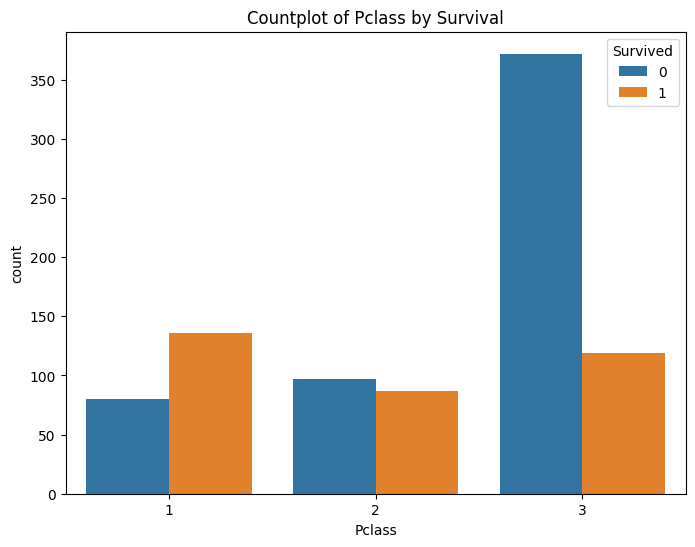

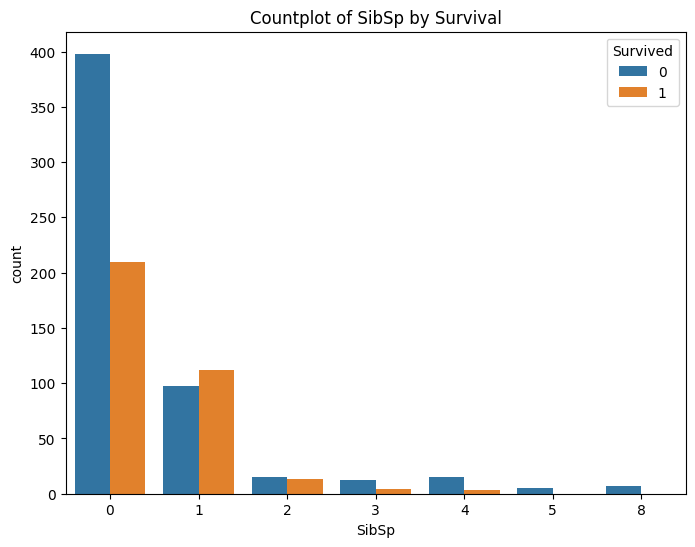

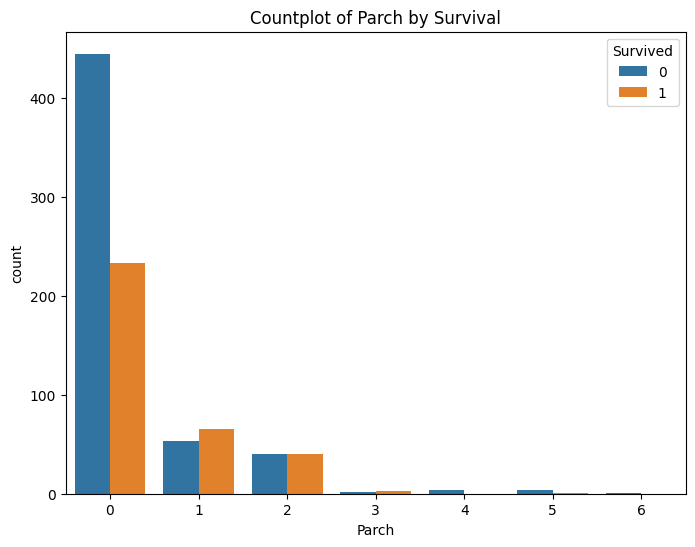

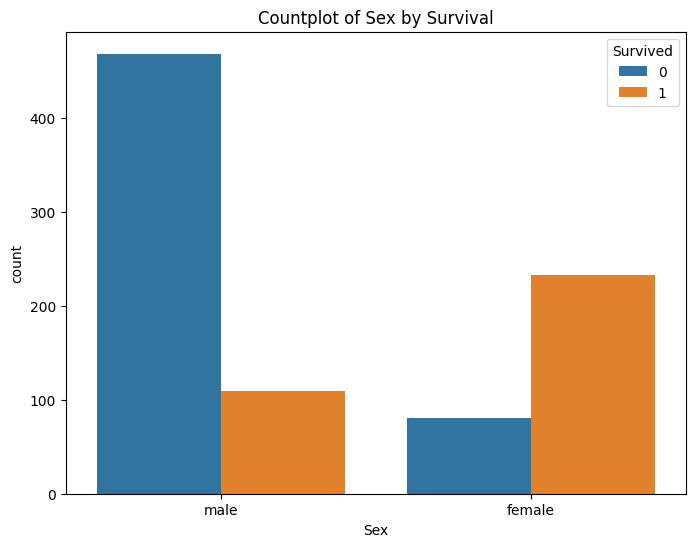

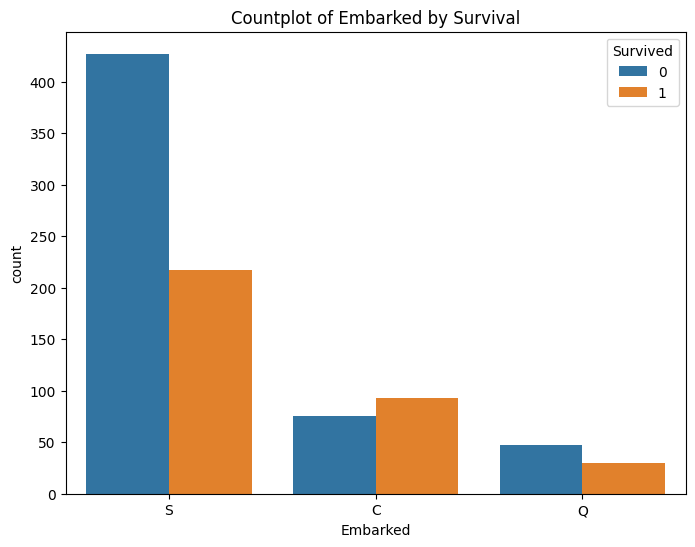

In [8]:
columns = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
for col in columns:
    plt.figure(figsize=(8, 6))
    sb.countplot(data=train, x=col, hue='Survived')
    plt.title(f'Countplot of {col} by Survival')
    plt.show()

In [9]:
pclass_mapping = {1: 0, 2: 1, 3: 2}

# Apply the mapping to the Pclass column
for dataset in combine:
    dataset['Pclass'] = dataset['Pclass'].map(pclass_mapping)
    dataset['Pclass'] = dataset['Pclass'].astype('object')

In [10]:
(train[train['Survived'] == 1].groupby('Embarked').size() * 100 / train.groupby('Embarked').size()).sort_values(ascending=False)

Embarked
C    55.357143
Q    38.961039
S    33.695652
dtype: float64

In [11]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
sex_mapping = {'female': 0, 'male': 1}
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    dataset['Sex'] = dataset['Sex'].astype('object')

In [13]:
for dataset in combine:
    embarked_dummies = pd.get_dummies(dataset['Embarked'], prefix='Embarked')
    dataset = dataset.drop('Embarked', axis=1)
    dataset = pd.concat([dataset, embarked_dummies], axis=1)

In [14]:
train.loc[:, 'Age'] = train['Age'].fillna(train['Age'].mean())
test.loc[:, 'Age'] = test['Age'].fillna(train['Age'].mean())

In [15]:
train.loc[:, 'Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test.loc[:, 'Fare'] = test['Fare'].fillna(train['Fare'].mean())

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encoded_train_col = encoder.fit_transform(train[['Embarked']])
encoded_train_df = pd.DataFrame(encoded_train_col, columns=encoder.get_feature_names_out(['Embarked']))

encoded_test_col = encoder.transform(test[['Embarked']])
encoded_test_df = pd.DataFrame(encoded_test_col, columns=encoder.get_feature_names_out(['Embarked']))

train = train.drop('Embarked', axis=1)
test = test.drop('Embarked', axis=1)

train = pd.concat([train.reset_index(drop=True), encoded_train_df], axis=1)
test = pd.concat([test.reset_index(drop=True), encoded_test_df], axis=1)

In [17]:
numeric_columns = list(train.select_dtypes(include=np.number).columns)
numeric_columns = [col for col in numeric_columns if col not in ['Survived', 'PassengerId']]
print(numeric_columns)

['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_train = train['Survived']
train.drop(['Survived'], axis=1, inplace=True)
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])
test[numeric_columns] = scaler.transform(test[numeric_columns])

In [19]:
train.drop(columns='PassengerId', axis=1, inplace=True)
PassengerId_test = test['PassengerId']
test.drop(columns='PassengerId', axis=1, inplace=True)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_CV, y_train, y_CV = train_test_split(train, y_train, test_size=0.2, random_state=42)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_CV)
nb_accuracy = accuracy_score(y_CV, nb_predictions)
print(f'Naive Bayes Accuracy: {nb_accuracy:.2f}')

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_CV)
rf_accuracy = accuracy_score(y_CV, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

# AdaBoost
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_model.fit(X_train, y_train)
ab_predictions = ab_model.predict(X_CV)
ab_accuracy = accuracy_score(y_CV, ab_predictions)
print(f'AdaBoost Accuracy: {ab_accuracy:.2f}')

Naive Bayes Accuracy: 0.78
Random Forest Accuracy: 0.83
AdaBoost Accuracy: 0.82


In [21]:
print(f'train shape: {train.shape}')
print(f'y_train shape: {y_train.shape}')


train shape: (891, 9)
y_train shape: (712,)


In [22]:
train.info


<bound method DataFrame.info of     Pclass Sex       Age     SibSp     Parch      Fare  Embarked_C  \
0        2   1 -0.592481  0.432793 -0.473674 -0.502445   -0.482043   
1        0   0  0.638789  0.432793 -0.473674  0.786845    2.074505   
2        2   0 -0.284663 -0.474545 -0.473674 -0.488854   -0.482043   
3        0   0  0.407926  0.432793 -0.473674  0.420730   -0.482043   
4        2   1  0.407926 -0.474545 -0.473674 -0.486337   -0.482043   
..     ...  ..       ...       ...       ...       ...         ...   
886      1   1 -0.207709 -0.474545 -0.473674 -0.386671   -0.482043   
887      0   0 -0.823344 -0.474545 -0.473674 -0.044381   -0.482043   
888      2   0  0.000000  0.432793  2.008933 -0.176263   -0.482043   
889      0   1 -0.284663 -0.474545 -0.473674 -0.044381    2.074505   
890      2   1  0.177063 -0.474545 -0.473674 -0.492378   -0.482043   

     Embarked_Q  Embarked_S  
0     -0.307562    0.615838  
1     -0.307562   -1.623803  
2     -0.307562    0.615838  
3     -

In [23]:
y_train

331    0
733    0
382    0
704    0
813    0
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 712, dtype: int64

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_model = SVC(random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_svm.fit(X_train, y_train)
print(f'Best parameters for SVM: {grid_search_svm.best_params_}')
print(f'Best accuracy for SVM: {grid_search_svm.best_score_:.2f}')



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy for SVM: 0.82


In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_dt.fit(X_train, y_train)
print(f'Best parameters for Decision Trees: {grid_search_dt.best_params_}')
print(f'Best accuracy for Decision Trees: {grid_search_dt.best_score_:.2f}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Trees: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best accuracy for Decision Trees: 0.81


In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_knn.fit(X_train, y_train)
print(f'Best parameters for KNN: {grid_search_knn.best_params_}')
print(f'Best accuracy for KNN: {grid_search_knn.best_score_:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best accuracy for KNN: 0.80


In [27]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[

    ('svm', grid_search_svm.best_estimator_),
    ('rf', rf_model),
    ('knn', grid_search_knn.best_estimator_)
], voting='hard')

ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_CV)
ensemble_accuracy = accuracy_score(y_CV, ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy:.2f}')


Ensemble Accuracy: 0.84


In [28]:
submission = ab_model.predict(test)

In [29]:
submission_series = pd.Series(submission)
submission_series.columns = ['Survived']
submission_series = submission_series.astype(int)

In [30]:
submission_df = pd.concat([PassengerId_test, submission_series], axis =1)
submission_df.columns = ['PassengerId', 'Survived']
submission_df.set_index('PassengerId', inplace=True)
submission_df.to_csv('submission.csv')